# Task 2 - LSTM for time series classification

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sns.set_style("darkgrid")
sns.set(font_scale=1.3)

## Data import & EDA

In [3]:
DATA_PATH = 'data'
FILE_NAME_PREFIX = 'Ambient_Living_'
N_FILES = len(list(filter(lambda s: s.endswith('.csv'), os.listdir(DATA_PATH)))) - 1  # one of the csv files contains targets
N_FILES

216

In [4]:
def load_file(file_code, strip=False):
    df = pd.read_csv(f'{DATA_PATH}/{FILE_NAME_PREFIX}{file_code}.csv')
    
    if strip:
        df.columns = [c.strip() for c in df.columns]
    
    return df

### Data example

In [5]:
seq_id = 1
data_example = load_file(seq_id)
data_example.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


In [6]:
data_example.describe()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
count,27.000000,27.000000,27.000000,27.000000
mean,-0.232805,-0.082963,-0.077601,0.088889
std,0.216344,0.185614,0.240700,0.299465
min,-0.904760,-0.600000,-0.619050,-0.800000
25%,-0.309520,-0.200000,-0.285710,-0.075000
50%,-0.142860,-0.040000,-0.047619,0.150000
75%,-0.095238,0.040000,0.142860,0.325000
max,0.000000,0.160000,0.285710,0.500000


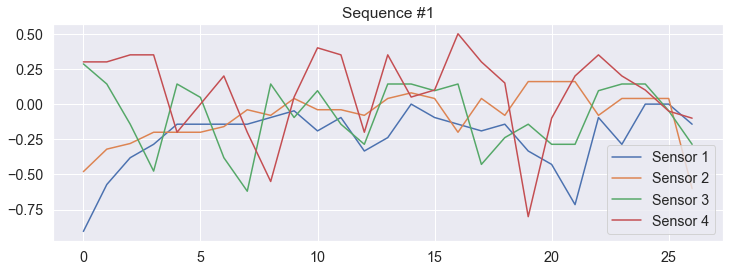

In [7]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=data_example, dashes=False)
_ = ax.set_title(f"Sequence #{seq_id}")

### Targets - class labels

In [8]:
targets = load_file('target', True)
targets.head()

,#sequence_ID,class_label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [9]:
targets['class_label'].value_counts()  # number of classes, class labels, number of examples per class

-1    111
 1    105
Name: class_label, dtype: int64

### All data files

In [10]:
all_data = {i: load_file(i) for i in range(1, N_FILES+1)}


In [11]:
descr = targets['class_label'].to_frame()
descr.index=targets['#sequence_ID']
descr['length'] = [d.shape[0] for d in all_data.values()]
descr['n_features'] = [d.shape[1] for d in all_data.values()]
descr.head()

,class_label,length,n_features
#sequence_ID,,,
1,1,27,4
2,1,26,4
3,1,23,4
4,1,23,4
5,1,25,4


In [12]:
descr[descr.columns[1:]].describe(percentiles=np.arange(0.2, 1, 0.2))

,length,n_features
count,216.000000,216.0
mean,37.407407,4.0
std,14.948306,0.0
min,19.000000,4.0
20%,24.000000,4.0
40%,27.000000,4.0
50%,33.500000,4.0
60%,40.000000,4.0
80%,54.000000,4.0
max,103.000000,4.0


## Pre-processing
### Adjust sequence lengths to the global 80th quantile

In [13]:
q_cut = 0.8  # cut the length at the 80th quantile
q_cut_value = int(descr['length'].quantile(q_cut))  # get the length corresponding to the quantile
q_cut_value

54

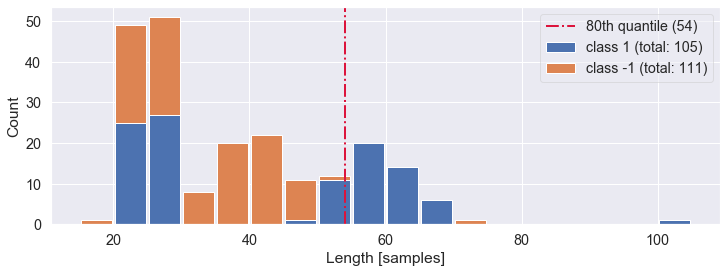

In [14]:
fig, ax = plt.subplots(figsize=(12,4))

w = 5
ln = descr['length']
labels_set = descr['class_label'].unique()
lengths_classes = [ln[descr['class_label'] == label] for label in labels_set]

hist = ax.hist(lengths_classes,
               bins=range(w*(min(ln)//w), max(ln)+w, w),
               label=[f'class {label} (total: {len(lengths_classes[i])})' for i, label in enumerate(labels_set)],
               stacked=True, rwidth=0.9)

ax.axvline(q_cut_value, color='crimson', linestyle='-.', lw=2, label=f'{100*q_cut:.0f}th quantile ({q_cut_value})')

ax.legend(fancybox=True, framealpha=0.5)
ax.set_xlabel("Length [samples]")
ax.set_ylabel("Count")
plt.show()

In [15]:
# prepare array for the pre-processed data (216x54x4)
all_data_prep = np.zeros((len(all_data), q_cut_value, all_data[1].shape[1]))

# fill the array with data for cropped sequences (the padding to 0 is automatic by non-filling the already zero-filled rows)
for i, sequence in enumerate(all_data.values()):
    all_data_prep[i, :min(q_cut_value, sequence.shape[0]), :] = sequence.iloc[:q_cut_value, :]

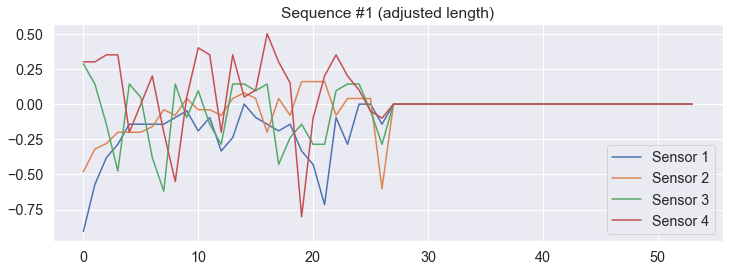

In [16]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=all_data_prep[0], dashes=False)
_ = ax.set_title(f"Sequence #{seq_id} (adjusted length)")
_ = ax.legend(data_example.columns)

### Dataset split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# split the data after random shuffle with train:test proportion 3:1 (0.75, 0.25)
all_labels = (targets['class_label'].values+1)/2
X_train, X_test, y_train, y_test = train_test_split(all_data_prep, all_labels, test_size=0.25)

In [19]:
X_train.shape

(162, 54, 4)

In [20]:
X_test.shape

(54, 54, 4)

In [21]:
y_test

array([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 1.])

## LSTM

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [23]:
model = Sequential()
model.add(LSTM(256, input_shape=all_data_prep.shape[1:]))
model.add(Dense(1, activation='sigmoid'))
model

In [24]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, batch_size=128, callbacks=[chk], validation_data=(X_test, y_test))

Epoch 1/200
2/2 [==============================] - 1s 405ms/step - loss: 0.6918 - accuracy: 0.5494 - val_loss: 0.6807 - val_accuracy: 0.6296
Epoch 2/200
2/2 [==============================] - 0s 122ms/step - loss: 0.6769 - accuracy: 0.5309 - val_loss: 0.6698 - val_accuracy: 0.5000
Epoch 3/200
2/2 [==============================] - 0s 123ms/step - loss: 0.6744 - accuracy: 0.5556 - val_loss: 0.6549 - val_accuracy: 0.5741
Epoch 4/200
2/2 [==============================] - 0s 124ms/step - loss: 0.6629 - accuracy: 0.6049 - val_loss: 0.6362 - val_accuracy: 0.6481
Epoch 5/200
2/2 [==============================] - 0s 122ms/step - loss: 0.6404 - accuracy: 0.6173 - val_loss: 0.6319 - val_accuracy: 0.5926
Epoch 6/200
2/2 [==============================] - 0s 121ms/step - loss: 0.6243 - accuracy: 0.5617 - val_loss: 0.5779 - val_accuracy: 0.7593
Epoch 7/200
2/2 [==============================] - 0s 125ms/step - loss: 0.5915 - accuracy: 0.6728 - val_loss: 0.5335 - val_accuracy: 0.7593
Epoch 8/200
2

2/2 [==============================] - 0s 119ms/step - loss: 0.3379 - accuracy: 0.8333 - val_loss: 0.3774 - val_accuracy: 0.7778
Epoch 29/200
2/2 [==============================] - 0s 120ms/step - loss: 0.3327 - accuracy: 0.8519 - val_loss: 0.4523 - val_accuracy: 0.7407
Epoch 30/200
2/2 [==============================] - 0s 119ms/step - loss: 0.3821 - accuracy: 0.8457 - val_loss: 0.3864 - val_accuracy: 0.7778
Epoch 31/200
2/2 [==============================] - 0s 114ms/step - loss: 0.3597 - accuracy: 0.8457 - val_loss: 0.4617 - val_accuracy: 0.7407
Epoch 32/200
2/2 [==============================] - 0s 146ms/step - loss: 0.5157 - accuracy: 0.7716 - val_loss: 0.4533 - val_accuracy: 0.7963
Epoch 33/200
2/2 [==============================] - 0s 137ms/step - loss: 0.4149 - accuracy: 0.7778 - val_loss: 0.4761 - val_accuracy: 0.7778
Epoch 34/200
2/2 [==============================] - 0s 137ms/step - loss: 0.4900 - accuracy: 0.7778 - val_loss: 0.4672 - val_accuracy: 0.7963
Epoch 35/200
2/2 [=

Epoch 56/200
2/2 [==============================] - 0s 120ms/step - loss: 0.1747 - accuracy: 0.9444 - val_loss: 0.3137 - val_accuracy: 0.8889
Epoch 57/200
2/2 [==============================] - 0s 119ms/step - loss: 0.2232 - accuracy: 0.9012 - val_loss: 0.2869 - val_accuracy: 0.8333
Epoch 58/200
2/2 [==============================] - 0s 120ms/step - loss: 0.2429 - accuracy: 0.8765 - val_loss: 0.2615 - val_accuracy: 0.8519
Epoch 59/200
2/2 [==============================] - 0s 118ms/step - loss: 0.1368 - accuracy: 0.9506 - val_loss: 0.3063 - val_accuracy: 0.8889
Epoch 60/200
2/2 [==============================] - 0s 118ms/step - loss: 0.1145 - accuracy: 0.9198 - val_loss: 0.4164 - val_accuracy: 0.8519
Epoch 61/200
2/2 [==============================] - 0s 125ms/step - loss: 0.1245 - accuracy: 0.9506 - val_loss: 0.2962 - val_accuracy: 0.8889
Epoch 62/200
2/2 [==============================] - 0s 122ms/step - loss: 0.1693 - accuracy: 0.9568 - val_loss: 0.3198 - val_accuracy: 0.8889
Epoch 

2/2 [==============================] - 0s 129ms/step - loss: 0.1008 - accuracy: 0.9691 - val_loss: 0.2494 - val_accuracy: 0.9259
Epoch 84/200
2/2 [==============================] - 0s 122ms/step - loss: 0.0718 - accuracy: 0.9877 - val_loss: 0.3911 - val_accuracy: 0.8889
Epoch 85/200
2/2 [==============================] - 0s 182ms/step - loss: 0.0842 - accuracy: 0.9630 - val_loss: 0.4154 - val_accuracy: 0.8889
Epoch 86/200
2/2 [==============================] - 0s 157ms/step - loss: 0.0579 - accuracy: 0.9753 - val_loss: 0.3158 - val_accuracy: 0.9074
Epoch 87/200
2/2 [==============================] - 0s 136ms/step - loss: 0.0715 - accuracy: 0.9630 - val_loss: 0.2968 - val_accuracy: 0.9259
Epoch 88/200
2/2 [==============================] - 0s 158ms/step - loss: 0.1589 - accuracy: 0.9753 - val_loss: 0.3138 - val_accuracy: 0.8889
Epoch 89/200
2/2 [==============================] - 0s 156ms/step - loss: 0.0510 - accuracy: 0.9815 - val_loss: 0.2591 - val_accuracy: 0.9259
Epoch 90/200
2/2 [=

2/2 [==============================] - 0s 124ms/step - loss: 0.1026 - accuracy: 0.9630 - val_loss: 0.1875 - val_accuracy: 0.9444
Epoch 111/200
2/2 [==============================] - 0s 121ms/step - loss: 0.0999 - accuracy: 0.9691 - val_loss: 0.1914 - val_accuracy: 0.9444
Epoch 112/200
2/2 [==============================] - 0s 122ms/step - loss: 0.0762 - accuracy: 0.9753 - val_loss: 0.2438 - val_accuracy: 0.9259
Epoch 113/200
2/2 [==============================] - 0s 124ms/step - loss: 0.0725 - accuracy: 0.9753 - val_loss: 0.3415 - val_accuracy: 0.8889
Epoch 114/200
2/2 [==============================] - 0s 133ms/step - loss: 0.1080 - accuracy: 0.9691 - val_loss: 0.3140 - val_accuracy: 0.9259
Epoch 115/200
2/2 [==============================] - 0s 123ms/step - loss: 0.1425 - accuracy: 0.9506 - val_loss: 0.2225 - val_accuracy: 0.9444
Epoch 116/200
2/2 [==============================] - 0s 128ms/step - loss: 0.0596 - accuracy: 0.9877 - val_loss: 0.2809 - val_accuracy: 0.9074
Epoch 117/200

Epoch 138/200
2/2 [==============================] - 0s 119ms/step - loss: 0.0185 - accuracy: 0.9938 - val_loss: 0.3486 - val_accuracy: 0.9444
Epoch 139/200
2/2 [==============================] - 0s 141ms/step - loss: 0.0651 - accuracy: 0.9815 - val_loss: 0.3109 - val_accuracy: 0.9444
Epoch 140/200
2/2 [==============================] - 0s 149ms/step - loss: 0.0318 - accuracy: 0.9877 - val_loss: 0.2742 - val_accuracy: 0.9259
Epoch 141/200
2/2 [==============================] - 0s 191ms/step - loss: 0.0295 - accuracy: 0.9877 - val_loss: 0.4191 - val_accuracy: 0.9074
Epoch 142/200
2/2 [==============================] - 0s 170ms/step - loss: 0.0654 - accuracy: 0.9753 - val_loss: 0.3505 - val_accuracy: 0.9259
Epoch 143/200
2/2 [==============================] - 0s 162ms/step - loss: 0.0148 - accuracy: 0.9938 - val_loss: 0.2965 - val_accuracy: 0.9444
Epoch 144/200
2/2 [==============================] - 0s 153ms/step - loss: 0.0514 - accuracy: 0.9753 - val_loss: 0.3404 - val_accuracy: 0.9259

2/2 [==============================] - 0s 143ms/step - loss: 0.1258 - accuracy: 0.9444 - val_loss: 0.2475 - val_accuracy: 0.9259
Epoch 166/200
2/2 [==============================] - 0s 117ms/step - loss: 0.0503 - accuracy: 0.9753 - val_loss: 0.3629 - val_accuracy: 0.9074
Epoch 167/200
2/2 [==============================] - 0s 116ms/step - loss: 0.0464 - accuracy: 0.9877 - val_loss: 0.4222 - val_accuracy: 0.8889
Epoch 168/200
2/2 [==============================] - 0s 130ms/step - loss: 0.0919 - accuracy: 0.9691 - val_loss: 0.2491 - val_accuracy: 0.9259
Epoch 169/200
2/2 [==============================] - 0s 130ms/step - loss: 0.0499 - accuracy: 0.9877 - val_loss: 0.2360 - val_accuracy: 0.9259
Epoch 170/200
2/2 [==============================] - 0s 149ms/step - loss: 0.0734 - accuracy: 0.9630 - val_loss: 0.2024 - val_accuracy: 0.9444
Epoch 171/200
2/2 [==============================] - 0s 138ms/step - loss: 0.0442 - accuracy: 0.9938 - val_loss: 0.2762 - val_accuracy: 0.9259
Epoch 172/200

2/2 [==============================] - 0s 129ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4160 - val_accuracy: 0.9444
Epoch 193/200
2/2 [==============================] - 0s 117ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.4099 - val_accuracy: 0.9444
Epoch 194/200
2/2 [==============================] - 0s 120ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4143 - val_accuracy: 0.9259
Epoch 195/200
2/2 [==============================] - 0s 116ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.4257 - val_accuracy: 0.9259
Epoch 196/200
2/2 [==============================] - 0s 122ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.4399 - val_accuracy: 0.9259
Epoch 197/200
2/2 [==============================] - 0s 119ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4538 - val_accuracy: 0.9259
Epoch 198/200
2/2 [==============================] - 0s 122ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4642 - val_accuracy: 0.9259
Epoch 199/200

In [25]:
model = chk.model

from sklearn.metrics import accuracy_score
test_preds = (model.predict(X_test) > 0.5).astype("int32")
accuracy_score(y_test, test_preds)

0.9259259259259259

In [26]:
def scorer(estimator, X, y):
    pred = (estimator.predict(X) > 0.5).astype("int32")
    return accuracy_score(pred, y) 


In [27]:
scorer(model, X_test, y_test)

0.9259259259259259

In [28]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier



In [35]:
def make_lstm():
    lstm_model = Sequential()
    lstm_model.add(LSTM(256, input_shape=all_data_prep.shape[1:]))
    lstm_model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=0.001)
    lstm_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return lstm_model

chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
fit_params = dict(epochs=200, batch_size=128)


In [36]:
# define the 10-fold cross-validation split
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
# run the cross-validation
scores = cross_val_score(KerasClassifier(make_lstm, **fit_params), X=all_data_prep, y=all_labels, cv=kf, scoring=scorer)


Epoch 1/200
2/2 [==============================] - 0s 81ms/step - loss: 0.6979 - accuracy: 0.4593
Epoch 2/200
2/2 [==============================] - 0s 77ms/step - loss: 0.6875 - accuracy: 0.5116
Epoch 3/200
2/2 [==============================] - 0s 75ms/step - loss: 0.6750 - accuracy: 0.5291
Epoch 4/200
2/2 [==============================] - 0s 78ms/step - loss: 0.6598 - accuracy: 0.5930
Epoch 5/200
2/2 [==============================] - 0s 84ms/step - loss: 0.6409 - accuracy: 0.5930
Epoch 6/200
2/2 [==============================] - 0s 74ms/step - loss: 0.6135 - accuracy: 0.6221
Epoch 7/200
2/2 [==============================] - 0s 76ms/step - loss: 0.6119 - accuracy: 0.6337
Epoch 8/200
2/2 [==============================] - 0s 80ms/step - loss: 0.5522 - accuracy: 0.7267
Epoch 9/200
2/2 [==============================] - 0s 77ms/step - loss: 0.5428 - accuracy: 0.7035
Epoch 10/200
2/2 [==============================] - 0s 77ms/step - loss: 0.5258 - accuracy: 0.6977
Epoch 11/200
2/2 [=

2/2 [==============================] - 0s 76ms/step - loss: 0.1667 - accuracy: 0.9360
Epoch 84/200
2/2 [==============================] - 0s 73ms/step - loss: 0.2002 - accuracy: 0.9302
Epoch 85/200
2/2 [==============================] - 0s 78ms/step - loss: 0.1551 - accuracy: 0.9360
Epoch 86/200
2/2 [==============================] - 0s 76ms/step - loss: 0.1705 - accuracy: 0.9128
Epoch 87/200
2/2 [==============================] - 0s 74ms/step - loss: 0.1522 - accuracy: 0.9593
Epoch 88/200
2/2 [==============================] - 0s 78ms/step - loss: 0.1559 - accuracy: 0.9593
Epoch 89/200
2/2 [==============================] - 0s 77ms/step - loss: 0.1626 - accuracy: 0.9651
Epoch 90/200
2/2 [==============================] - 0s 76ms/step - loss: 0.1226 - accuracy: 0.9651
Epoch 91/200
2/2 [==============================] - 0s 76ms/step - loss: 0.1089 - accuracy: 0.9535
Epoch 92/200
2/2 [==============================] - 0s 104ms/step - loss: 0.1498 - accuracy: 0.9535
Epoch 93/200
2/2 [====

2/2 [==============================] - 0s 84ms/step - loss: 0.1636 - accuracy: 0.9593
Epoch 166/200
2/2 [==============================] - 0s 78ms/step - loss: 0.1140 - accuracy: 0.9535
Epoch 167/200
2/2 [==============================] - 0s 78ms/step - loss: 0.0787 - accuracy: 0.9826
Epoch 168/200
2/2 [==============================] - 0s 74ms/step - loss: 0.0702 - accuracy: 0.9651
Epoch 169/200
2/2 [==============================] - 0s 78ms/step - loss: 0.0936 - accuracy: 0.9593
Epoch 170/200
2/2 [==============================] - 0s 75ms/step - loss: 0.0645 - accuracy: 0.9767
Epoch 171/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0694 - accuracy: 0.9709
Epoch 172/200
2/2 [==============================] - 0s 85ms/step - loss: 0.0552 - accuracy: 0.9651
Epoch 173/200
2/2 [==============================] - 0s 82ms/step - loss: 0.0721 - accuracy: 0.9826
Epoch 174/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0575 - accuracy: 0.9767
Epoch 175/200


2/2 [==============================] - 0s 80ms/step - loss: 0.3095 - accuracy: 0.8439
Epoch 42/200
2/2 [==============================] - 0s 75ms/step - loss: 0.2999 - accuracy: 0.8555
Epoch 43/200
2/2 [==============================] - 0s 78ms/step - loss: 0.2215 - accuracy: 0.9017
Epoch 44/200
2/2 [==============================] - 0s 77ms/step - loss: 0.2377 - accuracy: 0.9075
Epoch 45/200
2/2 [==============================] - 0s 78ms/step - loss: 0.2467 - accuracy: 0.9017
Epoch 46/200
2/2 [==============================] - 0s 78ms/step - loss: 0.2699 - accuracy: 0.9133
Epoch 47/200
2/2 [==============================] - 0s 75ms/step - loss: 0.2590 - accuracy: 0.8960
Epoch 48/200
2/2 [==============================] - 0s 76ms/step - loss: 0.2636 - accuracy: 0.8613
Epoch 49/200
2/2 [==============================] - 0s 76ms/step - loss: 0.1699 - accuracy: 0.9191
Epoch 50/200
2/2 [==============================] - 0s 81ms/step - loss: 0.1994 - accuracy: 0.9191
Epoch 51/200
2/2 [=====

2/2 [==============================] - 0s 79ms/step - loss: 0.1192 - accuracy: 0.9595
Epoch 124/200
2/2 [==============================] - 0s 79ms/step - loss: 0.1268 - accuracy: 0.9422
Epoch 125/200
2/2 [==============================] - 0s 78ms/step - loss: 0.1012 - accuracy: 0.9653
Epoch 126/200
2/2 [==============================] - 0s 81ms/step - loss: 0.0744 - accuracy: 0.9711
Epoch 127/200
2/2 [==============================] - 0s 78ms/step - loss: 0.0769 - accuracy: 0.9769
Epoch 128/200
2/2 [==============================] - 0s 77ms/step - loss: 0.0682 - accuracy: 0.9769
Epoch 129/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0526 - accuracy: 0.9827
Epoch 130/200
2/2 [==============================] - 0s 82ms/step - loss: 0.0610 - accuracy: 0.9884
Epoch 131/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0446 - accuracy: 0.9827
Epoch 132/200
2/2 [==============================] - 0s 77ms/step - loss: 0.0377 - accuracy: 0.9884
Epoch 133/200


2/2 [==============================] - 0s 79ms/step - loss: 0.6161 - accuracy: 0.6358
Epoch 6/200
2/2 [==============================] - 0s 81ms/step - loss: 0.6226 - accuracy: 0.6301
Epoch 7/200
2/2 [==============================] - 0s 91ms/step - loss: 0.6120 - accuracy: 0.6705
Epoch 8/200
2/2 [==============================] - 0s 94ms/step - loss: 0.6037 - accuracy: 0.7283
Epoch 9/200
2/2 [==============================] - 0s 91ms/step - loss: 0.5842 - accuracy: 0.6936
Epoch 10/200
2/2 [==============================] - 0s 78ms/step - loss: 0.5601 - accuracy: 0.6532
Epoch 11/200
2/2 [==============================] - 0s 95ms/step - loss: 0.5355 - accuracy: 0.7341
Epoch 12/200
2/2 [==============================] - 0s 84ms/step - loss: 0.5137 - accuracy: 0.7341
Epoch 13/200
2/2 [==============================] - 0s 93ms/step - loss: 0.4903 - accuracy: 0.7572
Epoch 14/200
2/2 [==============================] - 0s 95ms/step - loss: 0.4637 - accuracy: 0.7630
Epoch 15/200
2/2 [=========

2/2 [==============================] - 0s 79ms/step - loss: 0.0621 - accuracy: 0.9769
Epoch 88/200
2/2 [==============================] - 0s 81ms/step - loss: 0.0645 - accuracy: 0.9769
Epoch 89/200
2/2 [==============================] - 0s 78ms/step - loss: 0.0568 - accuracy: 0.9827
Epoch 90/200
2/2 [==============================] - 0s 78ms/step - loss: 0.0620 - accuracy: 0.9827
Epoch 91/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0589 - accuracy: 0.9884
Epoch 92/200
2/2 [==============================] - 0s 85ms/step - loss: 0.0625 - accuracy: 0.9769
Epoch 93/200
2/2 [==============================] - 0s 80ms/step - loss: 0.0493 - accuracy: 0.9827
Epoch 94/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0403 - accuracy: 0.9827
Epoch 95/200
2/2 [==============================] - 0s 78ms/step - loss: 0.0492 - accuracy: 0.9827
Epoch 96/200
2/2 [==============================] - 0s 92ms/step - loss: 0.0310 - accuracy: 0.9827
Epoch 97/200
2/2 [=====

2/2 [==============================] - 0s 79ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 170/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 171/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 172/200
2/2 [==============================] - 0s 81ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 173/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 174/200
2/2 [==============================] - 0s 78ms/step - loss: 9.1728e-04 - accuracy: 1.0000
Epoch 175/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 176/200
2/2 [==============================] - 0s 78ms/step - loss: 9.2837e-04 - accuracy: 1.0000
Epoch 177/200
2/2 [==============================] - 0s 79ms/step - loss: 8.6575e-04 - accuracy: 1.0000
Epoch 178/200
2/2 [==============================] - 0s 78ms/step - loss: 9.0353e-04 - accuracy: 1.000

2/2 [==============================] - 0s 76ms/step - loss: 0.2477 - accuracy: 0.9075
Epoch 51/200
2/2 [==============================] - 0s 73ms/step - loss: 0.2613 - accuracy: 0.8902
Epoch 52/200
2/2 [==============================] - 0s 79ms/step - loss: 0.2462 - accuracy: 0.8728
Epoch 53/200
2/2 [==============================] - 0s 76ms/step - loss: 0.2385 - accuracy: 0.8786
Epoch 54/200
2/2 [==============================] - 0s 74ms/step - loss: 0.2425 - accuracy: 0.9249
Epoch 55/200
2/2 [==============================] - 0s 75ms/step - loss: 0.2036 - accuracy: 0.9075
Epoch 56/200
2/2 [==============================] - 0s 74ms/step - loss: 0.3557 - accuracy: 0.9075
Epoch 57/200
2/2 [==============================] - 0s 75ms/step - loss: 0.2184 - accuracy: 0.9191
Epoch 58/200
2/2 [==============================] - 0s 73ms/step - loss: 0.2362 - accuracy: 0.9191
Epoch 59/200
2/2 [==============================] - 0s 84ms/step - loss: 0.1610 - accuracy: 0.9422
Epoch 60/200
2/2 [=====

2/2 [==============================] - 0s 76ms/step - loss: 0.0834 - accuracy: 0.9769
Epoch 133/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0758 - accuracy: 0.9884
Epoch 134/200
2/2 [==============================] - 0s 74ms/step - loss: 0.0521 - accuracy: 0.9827
Epoch 135/200
2/2 [==============================] - 0s 74ms/step - loss: 0.0474 - accuracy: 0.9827
Epoch 136/200
2/2 [==============================] - 0s 75ms/step - loss: 0.0307 - accuracy: 0.9942
Epoch 137/200
2/2 [==============================] - 0s 81ms/step - loss: 0.0228 - accuracy: 0.9942
Epoch 138/200
2/2 [==============================] - 0s 75ms/step - loss: 0.0444 - accuracy: 0.9942
Epoch 139/200
2/2 [==============================] - 0s 74ms/step - loss: 0.0331 - accuracy: 0.9827
Epoch 140/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0482 - accuracy: 0.9942
Epoch 141/200
2/2 [==============================] - 0s 78ms/step - loss: 0.0593 - accuracy: 0.9827
Epoch 142/200


2/2 [==============================] - 0s 86ms/step - loss: 0.4300 - accuracy: 0.7977
Epoch 14/200
2/2 [==============================] - 0s 94ms/step - loss: 0.4542 - accuracy: 0.7514
Epoch 15/200
2/2 [==============================] - 0s 93ms/step - loss: 0.4045 - accuracy: 0.7861
Epoch 16/200
2/2 [==============================] - 0s 97ms/step - loss: 0.3723 - accuracy: 0.8382
Epoch 17/200
2/2 [==============================] - 0s 98ms/step - loss: 0.3844 - accuracy: 0.8439
Epoch 18/200
2/2 [==============================] - 0s 99ms/step - loss: 0.3491 - accuracy: 0.8671
Epoch 19/200
2/2 [==============================] - 0s 91ms/step - loss: 0.3501 - accuracy: 0.9017
Epoch 20/200
2/2 [==============================] - 0s 95ms/step - loss: 0.3360 - accuracy: 0.8382
Epoch 21/200
2/2 [==============================] - 0s 98ms/step - loss: 0.4148 - accuracy: 0.7803
Epoch 22/200
2/2 [==============================] - 0s 93ms/step - loss: 0.3940 - accuracy: 0.7919
Epoch 23/200
2/2 [=====

2/2 [==============================] - 0s 77ms/step - loss: 0.1378 - accuracy: 0.9653
Epoch 96/200
2/2 [==============================] - 0s 74ms/step - loss: 0.1021 - accuracy: 0.9653
Epoch 97/200
2/2 [==============================] - 0s 74ms/step - loss: 0.0838 - accuracy: 0.9595
Epoch 98/200
2/2 [==============================] - 0s 96ms/step - loss: 0.0600 - accuracy: 0.9711
Epoch 99/200
2/2 [==============================] - 0s 93ms/step - loss: 0.1358 - accuracy: 0.9653
Epoch 100/200
2/2 [==============================] - 0s 93ms/step - loss: 0.1762 - accuracy: 0.9480
Epoch 101/200
2/2 [==============================] - 0s 94ms/step - loss: 0.1360 - accuracy: 0.9191
Epoch 102/200
2/2 [==============================] - 0s 96ms/step - loss: 0.1513 - accuracy: 0.9595
Epoch 103/200
2/2 [==============================] - 0s 93ms/step - loss: 0.1230 - accuracy: 0.9422
Epoch 104/200
2/2 [==============================] - 0s 85ms/step - loss: 0.0807 - accuracy: 0.9769
Epoch 105/200
2/2 

In [ ]:
scores